## Packages

In [1]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
!pip install pmdarima
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
!pip install arch
from arch import arch_model
!pip install yfinance
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 1.4 MB 7.6 MB/s 
     |████████████████████████████████| 9.8 MB 38.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


     |████████████████████████████████| 899 kB 6.9 MB/s 
     |████████████████████████████████| 6.3 MB 9.4 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


## Loading the data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
raw_csv_data = pd.read_excel("/content/drive/MyDrive/Index3 excel.xlsx",header=2)
df_comp=raw_csv_data.copy()


df_comp.Close = np.log( df_comp.Close)


df_comp.date = pd.to_datetime(df_comp.Date, dayfirst = True)
df_comp.set_index("Date", inplace=True)
# df_comp=df_comp.asfreq('b')
# df_comp=df_comp.fillna(method='ffill')
#df_comp['IPC']=df_comp.Close

df_comp.head()


,Close
Date,
2021-01-04,10.707796
2021-01-05,10.712374
2021-01-06,10.727381
2021-01-07,10.740490
2021-01-08,10.752127


## Prueba de estacionalidad

In [5]:
adf_test= ADFTest(alpha=0.05)
adf_test.should_diff(df_comp.Close)

(0.43636117491294546, True)

## Splitting the Data

In [8]:
size = int(len(df_comp.Close)*0.8)
df, df_test = df_comp.Close.iloc[:size], df_comp.Close.iloc[size:]
df.head()

Date
2021-01-04    10.707796
2021-01-05    10.712374
2021-01-06    10.727381
2021-01-07    10.740490
2021-01-08    10.752127
Name: Close, dtype: float64

In [9]:
df.tail()

Date
2021-08-19    10.841527
2021-08-20    10.847672
2021-08-23    10.860049
2021-08-24    10.858710
2021-08-25    10.865619
Name: Close, dtype: float64

In [10]:
df_test.head()

Date
2021-08-26    10.864574
2021-08-27    10.867151
2021-08-30    10.870511
2021-08-31    10.883781
2021-09-01    10.863135
Name: Close, dtype: float64

In [11]:
df_test.tail()

Date
2021-10-18    10.872106
2021-10-19    10.866714
2021-10-20    10.864717
2021-10-21    10.859385
2021-10-22    10.856875
Name: Close, dtype: float64

## Fitting a Model

In [25]:
model_ar = ARIMA(df, order = (1,0,0))
results_ar = model_ar.fit()
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Close   No. Observations:                  164
Model:                     ARMA(1, 0)   Log Likelihood                 532.962
Method:                       css-mle   S.D. of innovations              0.009
Date:                Thu, 18 Nov 2021   AIC                          -1059.923
Time:                        22:25:15   BIC                          -1050.624
Sample:                             0   HQIC                         -1056.148
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          10.7861      0.044    243.924      0.000      10.699      10.873
ar.L1.Close     0.9886      0.011     90.807      0.000       0.967       1.010
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0116           +0.0000j            1.0116            0.0000
-----------------------------------------------------------------------------
"""

## Simple Forecasting

In [13]:
df.tail()

Date
2021-08-19    10.841527
2021-08-20    10.847672
2021-08-23    10.860049
2021-08-24    10.858710
2021-08-25    10.865619
Name: Close, dtype: float64

In [14]:
# create variables that will help us change the periods easily instead of typing them up every time
# make sure the start and end dates are business days, otherwise the code will result in an error
start_date = "2021-01-04"
end_date = "2021-08-25"

In [15]:
df_pred = results_ar.predict(start = start_date, end = end_date)

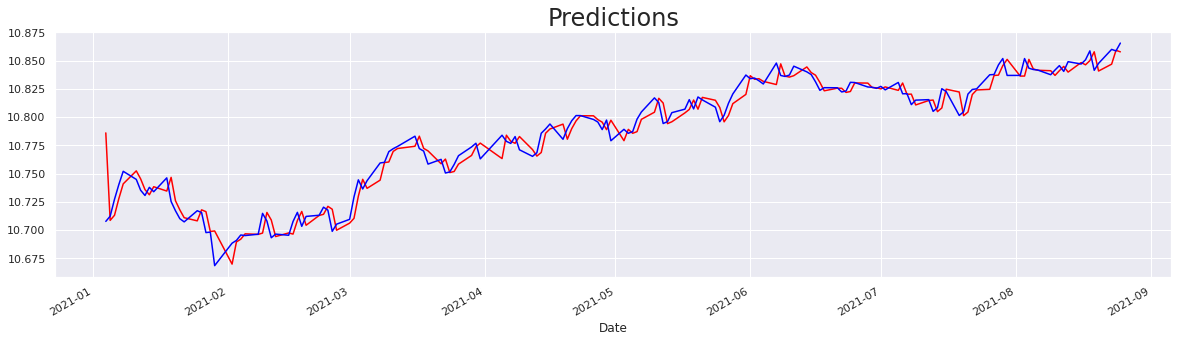

In [17]:
df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df[start_date:end_date].plot(color="blue")
plt.title("Predictions", size = 24)
plt.show()

### SARIMAX

In [74]:
start_date="2021-01-04"
end_date="2021-08-25"


model_sarimax = SARIMAX(df, exog = None, order = (1,1,1), seasonal_order = (0,0,0,0))
results_sarimax = model_sarimax.fit()

df_pred_sarimax = results_sarimax.predict(start = "2021-01-05", end = end_date, exog=None)

df_pred_sarimax[start_date:end_date].plot(figsize = (20,5), color = "red")
df[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

NameError: ignored

### Auto ARIMA

In [ ]:
model_auto = auto_arima(df.log, start_p=0, start_q=0, max_p=5, max_q=5, start_P=0, start_Q=0, D=1, max_P=5, max_Q=5, max_D=5, m=1, trace=True,stepwise=True, 
                         random_state=20, n_fits=50, criterion="aic", alpha=0.05,seasonal=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1060.354, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1060.076, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1060.403, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1060.575, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1061.501, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1058.915, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1057.411, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1059.846, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1058.985, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1056.320, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1057.360, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.901 seconds


### Forecasting Volatility

In [75]:
start_date="2021-01-04"
end_date="2021-08-25"


mod_garch = arch_model(df,vol = "GARCH", p = 1, q = 1, mean = "constant", dist = "Normal")
# res_garch = mod_garch.fit(last_obs = start_date, update_freq = 10)

In [ ]:
pred_garch = res_garch.forecast(horizon = 1, align = 'target')

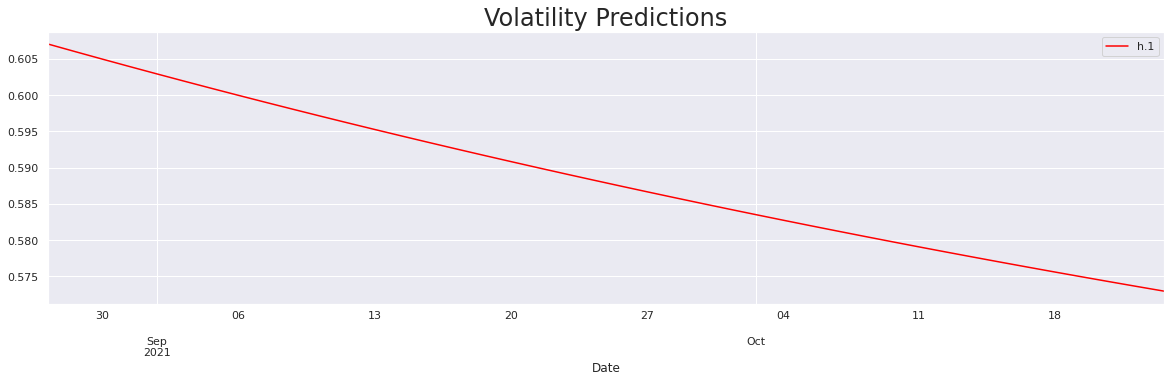

In [ ]:
pred_garch.residual_variance[start_date:].plot(figsize = (20,5), color = "red", zorder = 2)
plt.title("Volatility Predictions", size = 24)
plt.show()

In [61]:
pred_garch.residual_variance[start_date:].plot(figsize = (20,5), color = "red", zorder = 2)
df_test.abs().plot(color = "blue", zorder = 1)
plt.title("Volatility Predictions", size = 24)
plt.show()

NameError: ignored

In [ ]:
pred_garch = res_garch.forecast(horizon = 100, align = 'target')
pred_garch.residual_variance[-1:]

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,h.011,h.012,h.013,h.014,h.015,h.016,h.017,h.018,h.019,h.020,h.021,h.022,h.023,h.024,h.025,h.026,h.027,h.028,h.029,h.030,h.031,h.032,h.033,h.034,h.035,h.036,h.037,h.038,h.039,h.040,...,h.061,h.062,h.063,h.064,h.065,h.066,h.067,h.068,h.069,h.070,h.071,h.072,h.073,h.074,h.075,h.076,h.077,h.078,h.079,h.080,h.081,h.082,h.083,h.084,h.085,h.086,h.087,h.088,h.089,h.090,h.091,h.092,h.093,h.094,h.095,h.096,h.097,h.098,h.099,h.100
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-08-30,0.811449,0.805648,0.867232,0.940608,1.02073,1.084989,1.074064,1.067783,1.08121,1.090608,1.142407,1.121338,1.036393,1.11072,1.183629,1.257723,1.248608,1.336788,1.395024,1.014502,0.65149,0.691586,0.683082,0.701209,0.509165,0.491619,0.510821,0.490371,0.49208,0.512208,0.531597,0.528003,0.524606,0.523109,0.536405,0.555709,0.569648,0.590162,0.609764,0.63289,...,0.779928,0.790801,0.816335,0.836243,0.860533,0.85355,0.873285,0.827,0.8511,0.878126,0.888177,0.808246,0.829919,0.85095,0.859692,0.883821,0.883548,0.883613,0.855375,0.8605,0.882306,0.865465,0.886742,0.777604,0.790476,0.798239,0.800314,0.802961,0.810827,0.823701,0.837281,0.838888,0.830292,0.815455,0.827095,0.839331,0.850645,0.864163,0.871725,0.886197


### Multivariate Regression Model

In [66]:
from statsmodels.tsa.api import VAR

In [67]:
df = df[1:]

In [69]:
model_var = VAR(df)
model_var.select_order(20)
results_var = model_var.fit(ic = 'aic')

ValueError: ignored

In [73]:
results_var.summary()

NameError: ignored

In [72]:
lag_order= results_var.k_ar
var_pred = results_var.forecast(df.values[-lag_order:], len(df_test[start_date:end_date]))

df_pred = pd.DataFrame(data = var_pred, index = df_test[start_date:end_date].index,
                                columns = df_test[start_date:end_date].columns[4:8])

df_pred.nikkei[start_date:end_date].plot(figsize = (20,5), color = "red")

df_test[start_date:end_date].plot(color = "blue")
plt.title("Real vs Prediction", size = 24)
plt.show()

NameError: ignored

In [ ]:
results_var_ret.plot_forecast(1000)
plt.show()